##Introduction : Problem Statement

Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need.

While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

To improve on PMT, the IDB (the largest source of development financing for Latin America and the Caribbean) has turned to the Kaggle community. They believe that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance.

Beyond Costa Rica, many countries face this same problem of inaccurately assessing social need. If Kagglers can generate an improvement, the new algorithm could be implemented in other countries around the world.

Description about data and competition is given here  : https://www.kaggle.com/c/costa-rican-household-poverty-prediction/overview


## Reading Data and Importing Libraries

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c costa-rican-household-poverty-prediction

  0% 0.00/5.95k [00:00<?, ?B/s]
100% 5.95k/5.95k [00:00<00:00, 12.3MB/s]
  0% 0.00/13.5k [00:00<?, ?B/s]
100% 13.5k/13.5k [00:00<00:00, 7.15MB/s]
  0% 0.00/969k [00:00<?, ?B/s]
100% 969k/969k [00:00<00:00, 15.5MB/s]
  0% 0.00/395k [00:00<?, ?B/s]
100% 395k/395k [00:00<00:00, 13.0MB/s]
  0% 0.00/349k [00:00<?, ?B/s]
100% 349k/349k [00:00<00:00, 114MB/s]
  0% 0.00/59.7k [00:00<?, ?B/s]
100% 59.7k/59.7k [00:00<00:00, 49.4MB/s]
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [1]:
!unzip train.csv.zip 
!unzip test.csv.zip 

unzip:  cannot find or open train.csv.zip, train.csv.zip.zip or train.csv.zip.ZIP.
unzip:  cannot find or open test.csv.zip, test.csv.zip.zip or test.csv.zip.ZIP.


In [3]:
# will use a familiar stack of data science libraries: pandas, numpy, matplotlib, seaborn and eventually sklearn for modeling

# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

# ignore warnings
import warnings
warnings.filterwarnings(action='ignore') 

In [4]:
# read in data and look at summary information

pd.options.display.max_columns = 150

# read in DATA
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

FileNotFoundError: ignored

#### Integer Columns
Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.

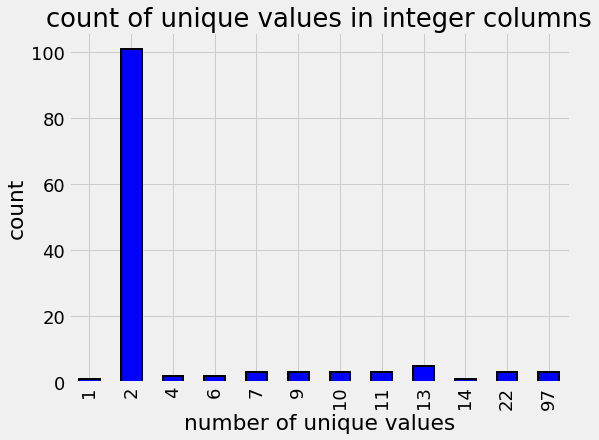

In [ ]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue',
                                                                             figsize = (8, 6),
                                                                             edgecolor = 'k', linewidth = 2);
plt.xlabel('number of unique values');
plt.ylabel('count');
plt.title('count of unique values in integer columns');

#### Float Columns

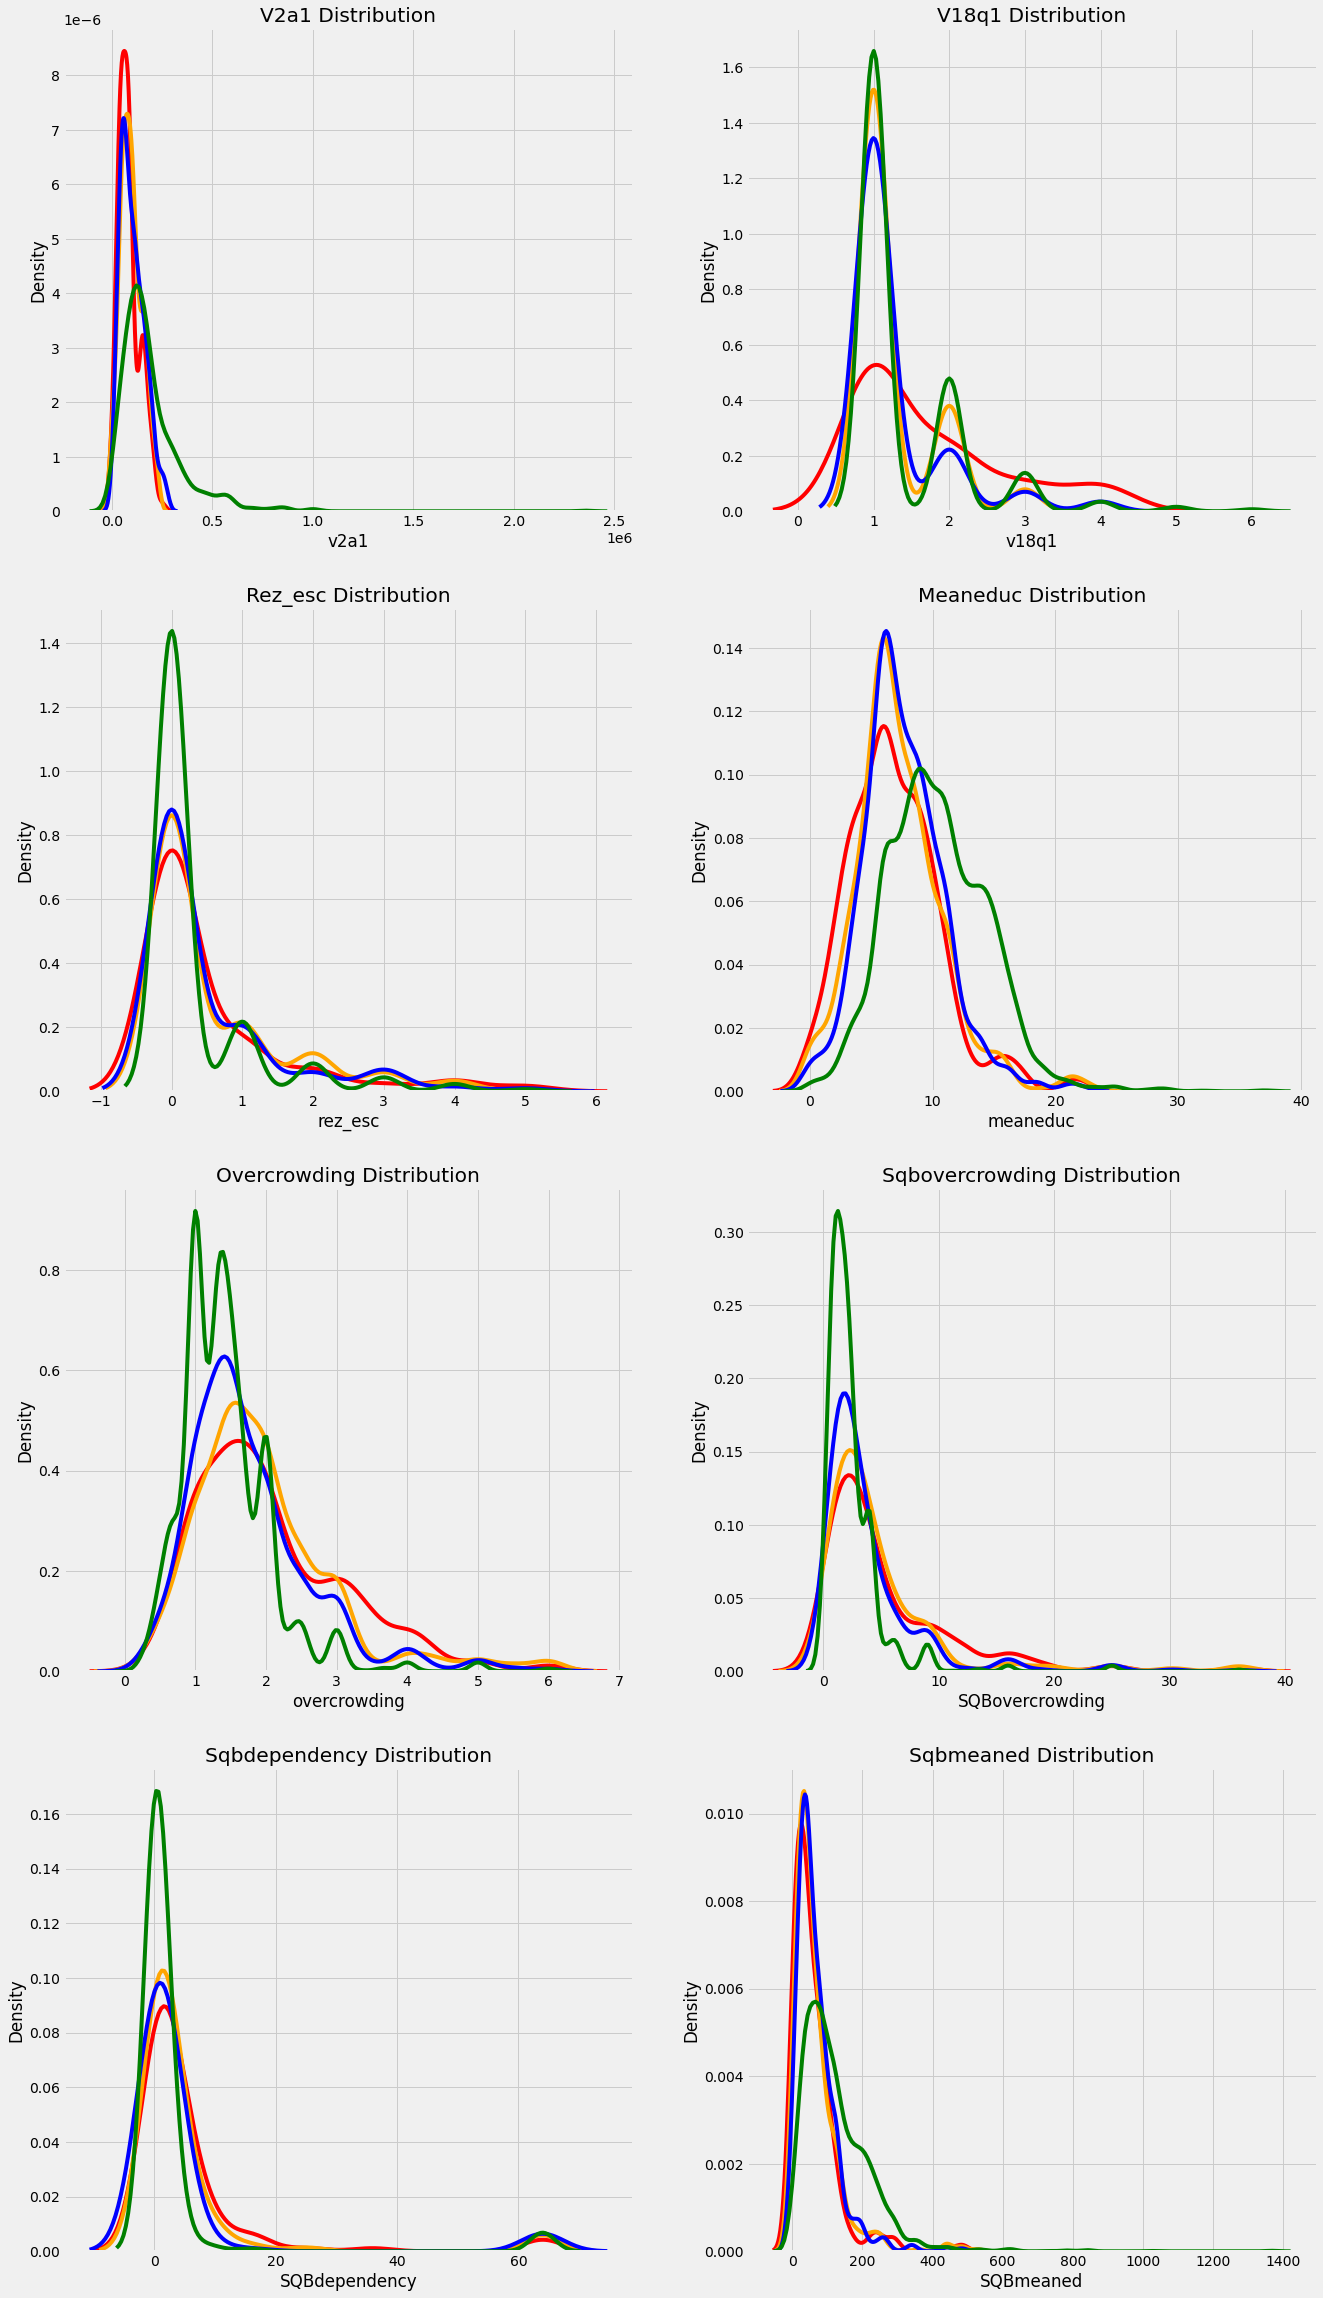

In [ ]:
# collections 모듈 OrderedDict 클래스를 사용하면 데이터의 순서 부여 
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    
    # iterate through the poverty levels
    for poverty_level, color in colors.items():
        # plot each poverty level as a seperate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(),
        ax = ax, color = color, label = poverty_mapping[poverty_level])
    
    plt.title(f'{col.capitalize()} Distribution');
    plt.xlabel(f'{col}');
    plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Later on we'll calculate correlations between the variables and the Target to gauge the relationships between the features, but these plots can already give us a sense of which variables may be most "relevant" to a model. For example, the meaneduc, representing the average education of the adults in the household appears to be related to the poverty level: a higher average adult education leads to higher values of the target which are less severe levels of poverty. The theme of the importance of education is one we will come back to again and again in this notebook!

#### Object Columns
The last column type is object which we can view as follows.

In [ ]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


The Id and idhogar object types make sense because these are identifying variables. However, the other columns seem to be a mix of strings and numbers which we'll need to address before doing any machine learning. 

In [ ]:
mapping = {'yes': 1, 'no': 0}

# apply same operation to both train and test
for df in [train, test]:
    # fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    
train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


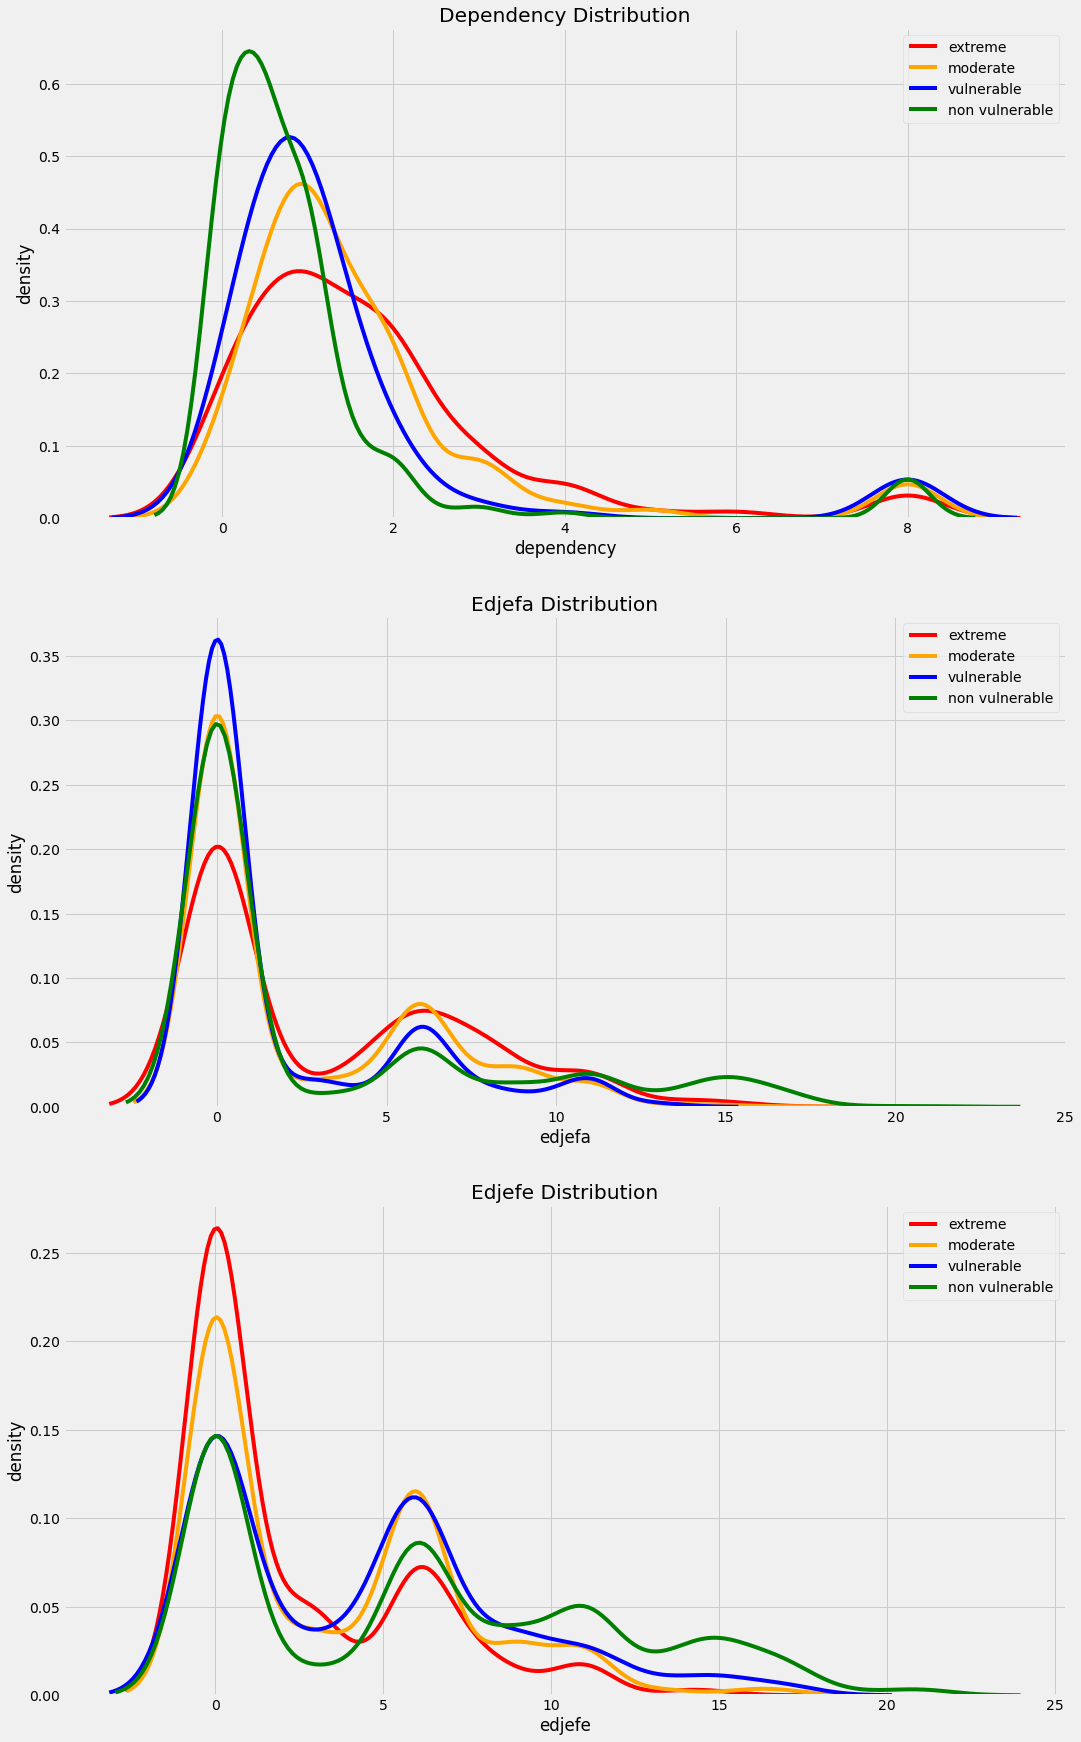

In [ ]:
plt.figure(figsize = (16, 12))

# iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i+1)
    # iterate through the poverty levels
    for poverty_level, color in colors.items():
        # plot each poverty level as a seperate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(),
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        plt.title(f'{col.capitalize()} Distribution');
        plt.xlabel(f'{col}');
        plt.legend();
        plt.ylabel('density')

    plt.subplots_adjust(top = 2)

These variables are now correctly represented as numbers and can be fed into a machine learning model.

To make operations like that above a little easier, we'll join together the training and testing dataframes. This is important once we start feature engineering because we want to apply the same operations to both dataframes so we end up with the same features. Later we can separate out the sets based on the Target.

In [ ]:
# add null target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

### Exploring Label Distribution

Next, we can get an idea of how imbalanced the problem is by looking at the distribution of labels. There are four possible integer levels, indicating four different levels of poverty. To look at the correct labels, we'll subset only to the columns where parentesco1 == 1 because this is the head of household, the correct label for each household.

The bar plot below shows the distribution of training labels (since there are no testing labels).

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

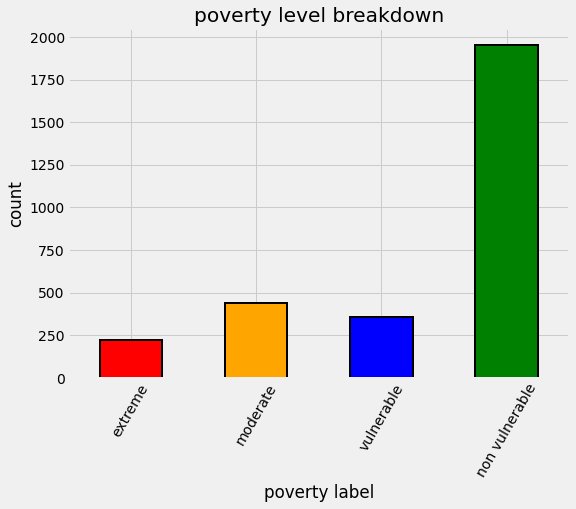

In [ ]:
# heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), 
                        ['Target', 'idhogar']]

# value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6),
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# formatting
plt.xlabel('poverty label');
plt.ylabel('count');
plt.xticks([x - 1 for x in poverty_mapping.keys()],
           list(poverty_mapping.values()), rotation = 60)
plt.title('poverty level breakdown');

label_counts

We are dealing with an imbalanced class problem (which makes it intriguing why the contest organizers choose the macro F1 score as the metric instead of weighted F1!). There are many more households that classify as non vulnerable than in any other category. The extreme poverty class is the smallest (I guess this should make us optimistic!).

One problem with imbalanced classification problems is that the machine learning model can have a difficult time predicting the minority classes because it sees far less examples. Think about this in human terms: if we are classifiying poverty and we see far more cases of no poverty than extreme poverty, it will make it more difficult for us to identify the high poverty households because of less exposure. One potential method to address class imbalanceds is through oversampling (which is covered in more advanced notebooks).

### Addressing Wrong Labels
As with any realistic dataset, the Costa Rican Poverty data has some issues. Typically, 80% of a data science project will be spent cleaning data and fixing anomalies/errors. These can be either human entry errors, measurement errors, or sometimes just extreme values that are correct but stand out. For this problem, some of the labels are not correct because individuals in the same household have a different poverty level. We're not told why this may be the case, but we are told to use the head of household as the true label.

That information makes our job much easier, but in a real-world problem, we would have to figure out the reason Why the labels are wrong and how to address the issue on our own. This section fixes the issue with the labels although it is not strictly necessary: I kept it in the notebook just to show how we may deal with this issue.

#### Identify Errors
First we need to find the errors before we can correct them. To find the households with different labels for family members, we can group the data by the household and then check if there is only one unique value of the Target.

In [ ]:
# groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x:x.nunique() == 1)

# households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('there are {} households where the family members do not all have the same target.'.format(len(not_equal)))

there are 85 households where the family members do not all have the same target.


In [ ]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


The organizers tell us that the correct label is that for the head of household, where parentesco1 == 1. For this household, the correct label is 3 for all members. We can correct this (as shown later) by reassigning all the individuals in this household the correct poverty level. In the real-world, you might have to make the tough decision of how to address the problem by yourself (or with the help of your team).

#### Families without Heads of Household
We can correct all the label discrepancies by assigning the individuals in the same household the label of the head of household. But wait, you may ask: "What if there are households without a head of household? And what if the members of those households have differing values of the label?"

In [ ]:
# standard by idhogar to plus parentsco1
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# fifnd households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('there are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

there are 15 households without a head.


In [ ]:
# find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

print('{} households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 households with no head have different labels.


Well that's a relief! This means that we don't have to worry about a household both where there is no head AND the members have different values of the label! For this problem, according to the organizers, if a household does not have a head, then there is no true label. Therefore, we actually won't use any of the households without a head for training Nonetheless, it's still a good exercise to go through this process of investigating the data!

##### Correct Errors
Now we can correct labels for the households that do have a head AND the members have different poverty levels.

In [ ]:
# iterate through each household
for household in not_equal.index:
    # find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
# groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('there are {} households where the family members do not all have the same target.'.format(len(not_equal)))

there are 0 households where the family members do not all have the same target.


Since we are only going to use the heads of household for the labels, this step is not completely necessary but it shows a workflow for correcting data errors like you may encounter in real life. Don't consider it extra work, just practice for your career!

#### Missing Variables
One of the most important steps of exploratory data analysis is finding missing values in the data and determining how to handle them. Missing values have to be filled in before we use a machine learning model and we need to think of the best strategy for filling them in based on the feature: this is where we'll have to start digging into the data definitions.

First we can look at the percentage of missing values in each column.

In [ ]:
# number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


We don't have to worry about the Target becuase we made that NaN for the test data. However, we do need to address the other 3 columns with a high percentage of missing values.

v18q1: Number of tablets

Let's start with v18q1 which indicates the number of tablets owned by a family. We can look at the value counts of this variable. Since this is a household variable, it only makes sense to look at it on a household level, so we'll only select the rows for the head of household.

#### Function to Plot Value Counts
Since we might want to plot value counts for different columns, we can write a simple function that will do it for us!

In [ ]:
def plot_value_counts(df, col, heads_only = False):
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                edgecolor = 'k',
                                                linewidth = 2)
    plt.xlabel(f'{col}');
    plt.title(f'{col} value counts');
    plt.ylabel('count');
    plt.show();

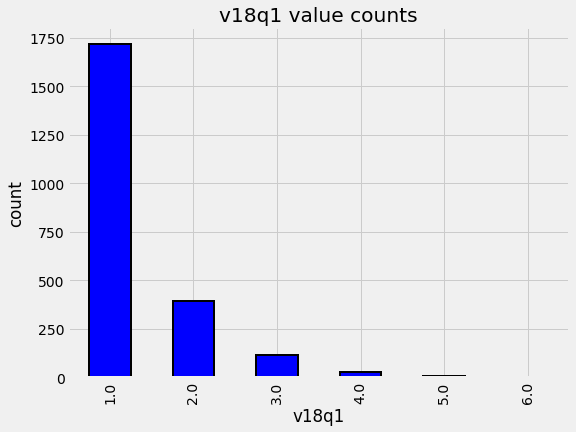

In [ ]:
plot_value_counts(heads, 'v18q1')

It looks like the most common number of tablets to own is 1 if we go only by the data that is present. However, we also need to think about the data that is missing. In this case, it could be that families with a nan in this category just do not own a tablet! If we look at the data definitions, we see that v18q indicates whether or not a family owns a tablet. We should investigate this column combined with the number of tablets to see if our hypothesis holds.

We can groupby the value of v18q (which is 1 for owns a tablet and 0 for does not) and then calculate the number of null values for v18q1. This will tell us if the null values represent that the family does not own a tablet.

In [ ]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

Well, that solves the issue! Every family that has nan for v18q1 does not own a tablet. Therefore, we can fill in this missing value with zero.

In [ ]:
data['v18q1'] = data['v18q1'].fillna(0)

v2a1: Monthly rent payment

The next missing column is v2a1 which represents the montly rent payment.

In addition to looking at the missing values of the monthly rent payment, it will be interesting to also look at the distribution of tipovivi_, the columns showing the ownership/renting status of the home. For this plot, we show the ownership status of those homes with a nan for the monthyl rent payment.

Text(0.5, 1.0, 'home ownership status for households missing rent payments')

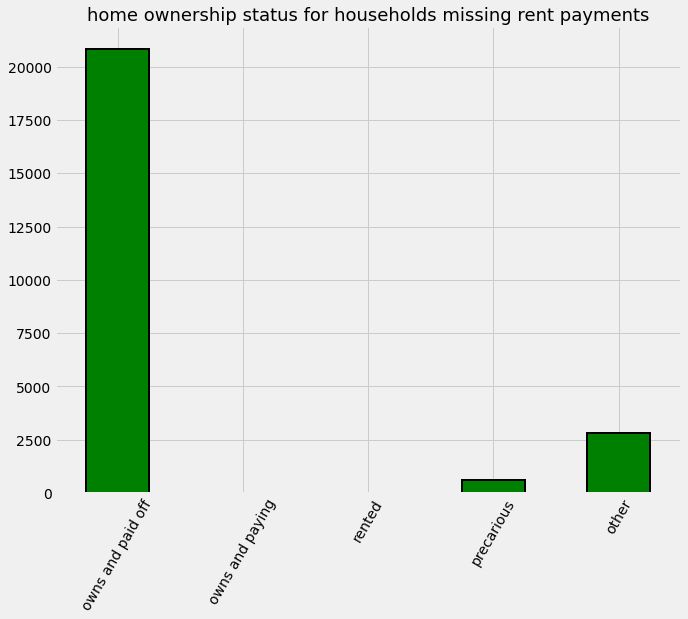

In [ ]:
# variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]

# plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                              color = 'green',
                                                              edgecolor = 'k',
                                                              linewidth = 2);
# matplotlib 눈금 표시하기
plt.xticks([0, 1, 2, 3, 4],
           ['owns and paid off', 'owns and paying', 'rented', 'precarious', 'other'],
           rotation = 60)

plt.title('home ownership status for households missing rent payments', size = 18)

In [ ]:
# fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

rez_esc: years behind in school

The last column with a high percentage of missing values is rez_esc indicating years behind in school. For the families with a null value, is possible that they have no children currently in school. Let's test this out by finding the ages of those who have a missing value in this column and the ages of those who do not have a missing value.

In [ ]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

What this tells us is that the oldest age with a missing value is 17. For anyone older than this, maybe we can assume that they are simply not in school. Let's look at the ages of those who have a missing value.

In [ ]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

If we read through some of the discussions for this competition, we learn that this variable is only defined for individuals between 7 and 19. Anyone younger or older than this range presumably has no years behind and therefore the value should be set to 0. For this variable, if the individual is over 19 and they have a missing value, or if they are younger than 7 and have a missing value we can set it to zero. For anyone else, we'll leave the value to be imputed and add a boolean flag.

In [ ]:
# if individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

There is also one outlier in the rez_esc column. Again, if we read through the competition discussions, we learn that the maximum value for this variable is 5. Therefore, any values above 5 should be set to 5.

## Plot Two Categorical Variables
To show how two categorical variables interact with one another, there are a number of plotting options: scatterplots, faceted bar plots, boxplots, etc. I wasn't satisfied with any of these choices so I wrote the function below, which essentially is a scatterplot of two categoricals where the size of the points represent the percentage of a given y-value represented by each x-value.

In [ ]:
def plot_categoricals(x, y, data, annotate = True):
    # raw counts
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # calculate the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    
    # scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # annotate the plot with text
        # Iterate over DataFrame rows as (index, Series) pairs.
        for i, row in counts.iterrows():
            # put text with appropariate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()),
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'],1 )}")
            
    # set tick marks
    plt.xticks(counts[y].unique())
    plt.yticks(counts[x].unique())
    
    # transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max, int((sqr_max - sqr_min) / 5)))
    
    markers = []
    
    # markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size,
                                   label = f'{int(round(np.square(size) / 100) * 100)}',
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor ='k', linewidth = 1.5))
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
        
    plt.annotate(f'* Size represnts raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()),
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()),
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}");
    plt.ylabel(f"{y}");
    plt.title(f"{y} vs {x}");

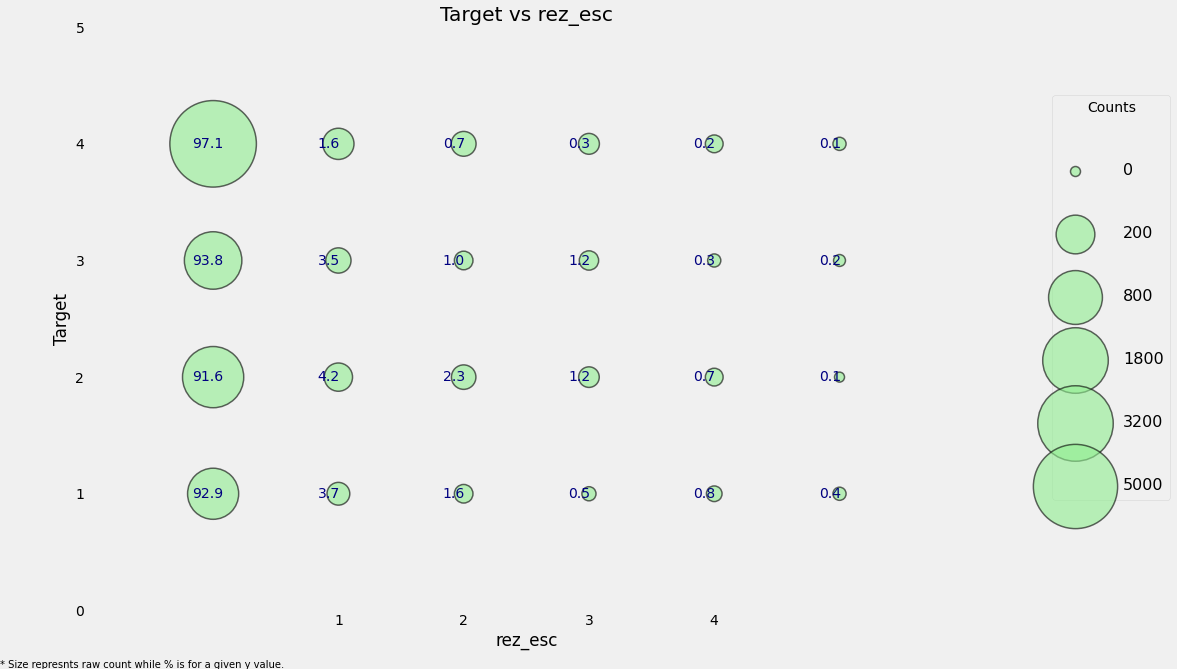

In [ ]:
plot_categoricals('rez_esc', 'Target', data);

The size of the markers represents the raw count. To read the plot, choose a given y-value and then read across the row. For example, with a poverty level of 1, 93% of individuals have no years behind with a total count of around 800 individuals and about 0.4% of individuals are 5 years behind with about 50 total individuals in this category. This plot attempts to show both the overall counts and the within category proportion; it's not perfect , but I gave it a shot!

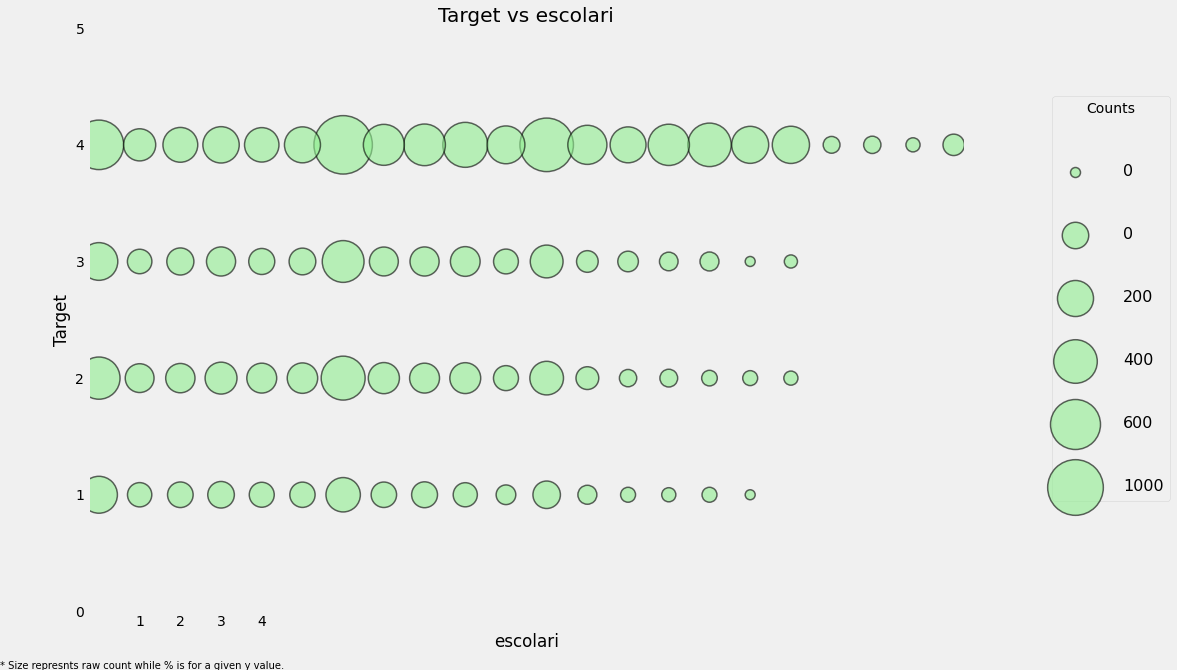

In [ ]:
plot_categoricals('escolari', 'Target', data, annotate = False)

The remaining missing values in each column will be filled in, a process known as Imputation. There are several types of imputation commonly used, and one of the simplest and most effective methods is to fill in the missing values with the median of the column.

As a final step with the missing values, we can plot the distribution of target for the case where either of these values are missing.

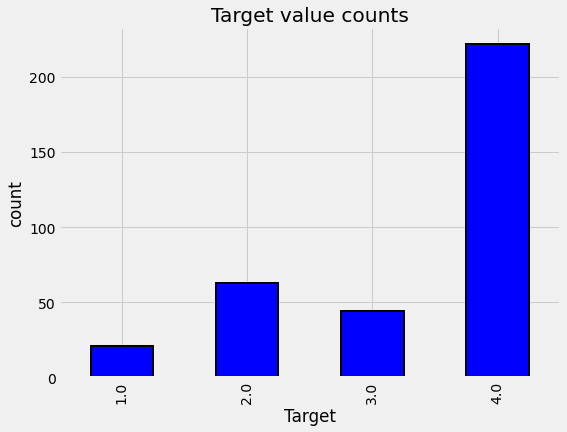

In [ ]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 'Target')

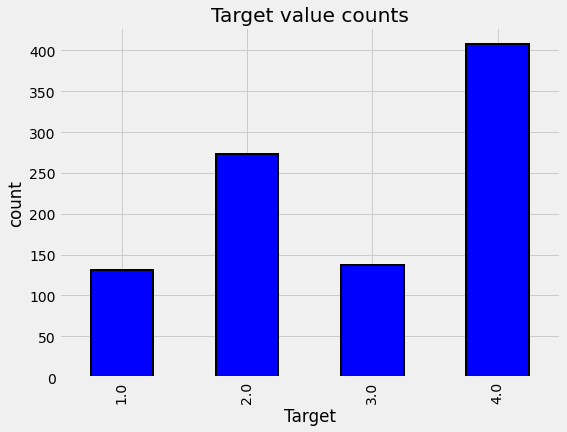

In [ ]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 'Target')

This looks like it could be an indicator of more poverty given the higher prevalence of 2: moderate poverty.

This represents an important point: sometimes the missing information is just as important as the information you are given.

## Feature Engineering
There is plenty more exploratory data analysis we can do, but first we should work on consolidating our data at a household level. We already have some of the information for each household, but for training, we will need all of the information summarized for each household. This means grouping the individuals in a house (groupby) and performing an aggregation (agg) of the individual variables.

In another notebook, I show how we can use automated feature engineering to do this, and automated feature engineering should be a standard part of the machine learning workflow. Right now, we'll stick to doing this by hand, but definitely take a look at automated feature engineering in Featuretools.

In [ ]:
id_ = ['Id', 'idhogar', 'Target']

ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

In [ ]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

print('there are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('we covered every variabl')

there are no repeats:  True
we covered every variabl


### Squared Variables
First, the easiest step: we'll remove all of the squared variables. Sometimes variables are squared or transformed as part of feature engineering because it can help linear models learn relationships that are non-linear. However, since we will be using more complex models, these squared features are redundant. They are highly correlated with the non-squared version, and hence can actually hurt our model by adding irrelevant information and also slowing down training.

For an example, let's take a look at SQBage vs age.

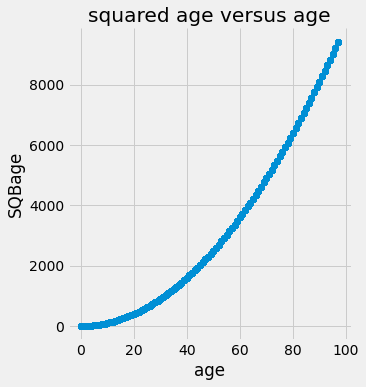

In [ ]:
sns.lmplot('age', 'SQBage', data = data, fit_reg = False);
plt.title('squared age versus age');

In [ ]:
# remove squared variables
data = data.drop(columns = sqr_)
data.shape

(33413, 136)

### Id Variables
These are pretty simple: they will be kept as is in the data since we need them for identification.

### Household Level Variables
First let's subset to the heads of household and then to the household level variables.

In [ ]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

For most of the household level variables, we can simply keep them as is: since we want to make predictions for each household, we use these variables as features. However, we can also remove some redundant variables and also add in some more features derived from existing data.

### Redundant Household Variables
Let's take a look at the correlations between all of the household variables. If there are any that are too highly correlated, then we might want to remove one of the pair of highly correlated variables.

The following code identifies any variables with a greater than 0.95 absolute magnitude correlation.

In [ ]:
# create a correlation matrix
corr_matrix = heads.corr()

# select upper triangle of correlation matrix
# np.triu() 상삼각행렬 (Upper triangular matrix)을 반환
# https://ko.wikipedia.org/wiki/%EC%82%BC%EA%B0%81%ED%96%89%EB%A0%AC
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

these show one out of each pair of correlated variables. To find the other pari, we can subset the corr_matrix

In [ ]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


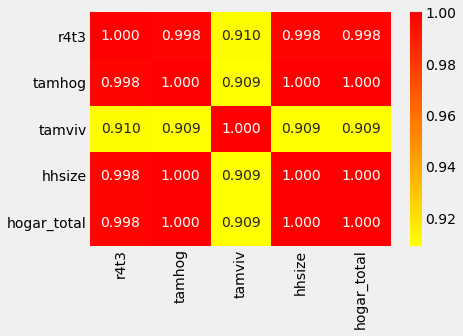

In [ ]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot = True, cmap = plt.cm.autumn_r, fmt = '.3f');

There are several variables here having to do with the size of the house:

* r4t3: Total persons in the household
* tamhog:  size of the household
* tamviv: number of persons living in the household
* hhsize: household size
* hogar_total: # of total individuals in the household

These variables are all highly correlated with one another. In fact, hhsize has a perfect correlation with tamhog and hogar_total. We will remove these two variables because the information is redundant. We can also remove r4t3 because it has a near perfect correlation with hhsize.

tamviv is not necessarily the same as hhsize because there might be family members that are not living in the household. Let's visualize this difference in a scatterplot.

In [ ]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

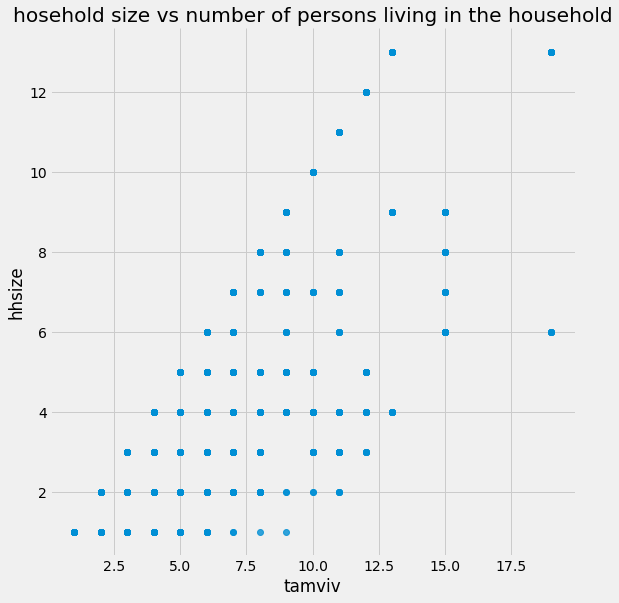

In [ ]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg = False, size = 8);
plt.title('hosehold size vs number of persons living in the household');

We see for a number of cases, there are more people living in the household than there are in the family. This gives us a good idea for a new feature: the difference between these two measurements!

Let's make this new feature.

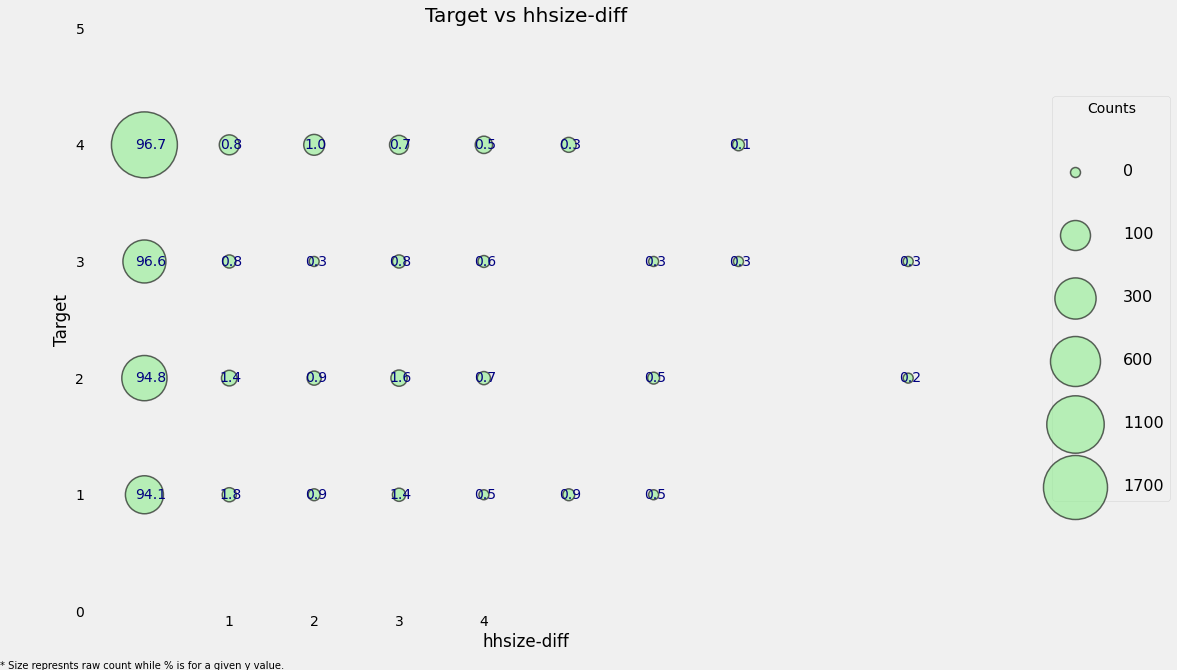

In [ ]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

Even though most households do not have a difference, there are a few that have more people living in the household than are members of the household.

Let's move on to the other redundant variables. First we can look at coopele

In [ ]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


These variables indicate where the electricity in the home is coming from. There are four options, and the families that don't have one of these two options either have no electricity (noelec) or get it from a private plant (planpri).

### Creating Ordinal Variable¶
I'm going to compress these four variables into one by creating an ordinal variable. I'm going to choose the mapping myself, based on the data decriptions:

* 0: No electricity
* 1: Electricity from cooperative
* 2: Electricity from CNFL, ICA, ESPH/JASEC
* 3: Electricity from private plant

An ordered variable has an inherent ordering, and for this we choose our own based on the domain knowledge. After we create this new ordered variable, we can drop the four others. There are several households that do not have a variable here, so we will use a nan (which will be filled in during imputation) and add a Boolean column indicating there was no measure for this variable.

In [ ]:
elec = []

# assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

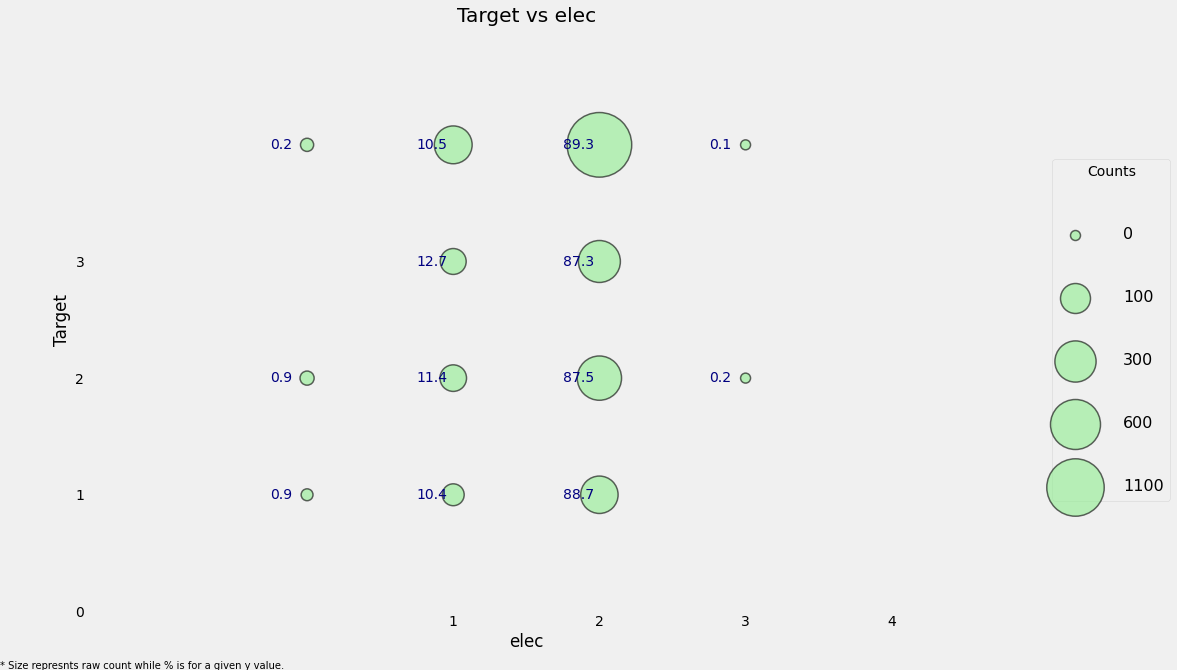

In [ ]:
plot_categoricals('elec', 'Target', heads)

We can see that for every value of the Target, the most common source of electricity is from one of the listed providers.

The final redundant column is area2. This means the house is in a rural zone, but it's redundant because we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.

In [ ]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0).

#### Creating Ordinal Variables
For the walls, roof, and floor of the house, there are three columns each: the first indicating 'bad', the second 'regular', and the third 'good'. We could leave the variables as booleans, but to me it makes more sense to turn them into ordinal variables because there is an inherent order: bad < regular < good. To do this, we can simply find whichever column is non-zero for each household using np.argmax.

Once we have created the ordinal variable, we are able to drop the original variables.

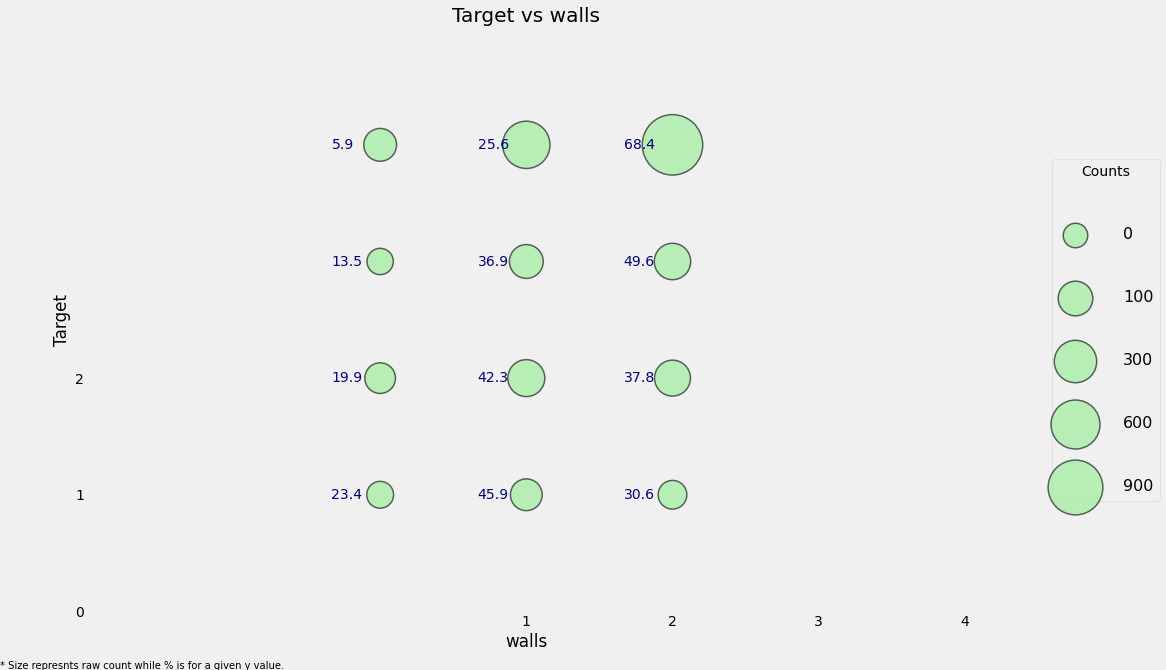

In [ ]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])
plot_categoricals('walls', 'Target', heads)

In [ ]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

### Feature Construction
In addition to mapping variables to ordinal features, we can also create entirely new features from the existing data, known as feature construction. For example, we can add up the previous three features we just created to get an overall measure of the quality of the house's structure.

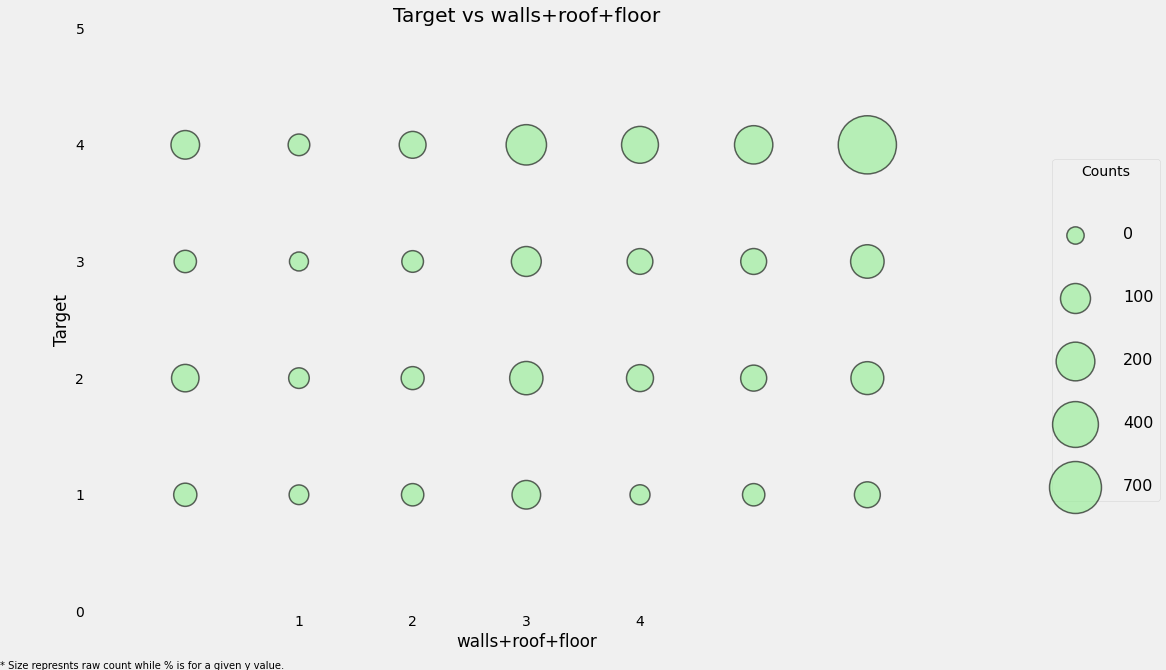

In [ ]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

This new feature may be useful because it seems like a Target of 4 (the lowest poverty level) tends to have higher values of the 'house quality' variable. We can also look at this in a table to get the fine-grained details.

In [ ]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target' : 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


The next variable will be a warning about the quality of the house. It will be a negative value, with -1 point each for no toilet, electricity, floor, water service, and ceiling.

In [ ]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

We can keep using our plot_categoricals function to visualize these relationships, but seaborn also has a number of plotting options that can work with categoricals. One is the violinplot which shows the distribution of a variable on the y axis with the width of each plot showing the number of observations in that category.

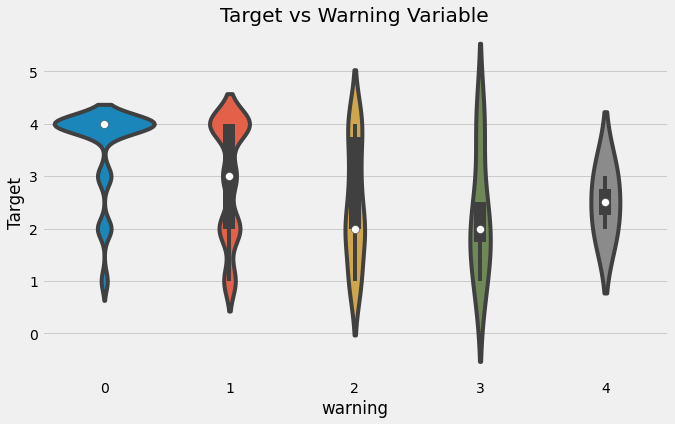

In [ ]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'warning', y = 'Target', data = heads);
plt.title('Target vs Warning Variable');

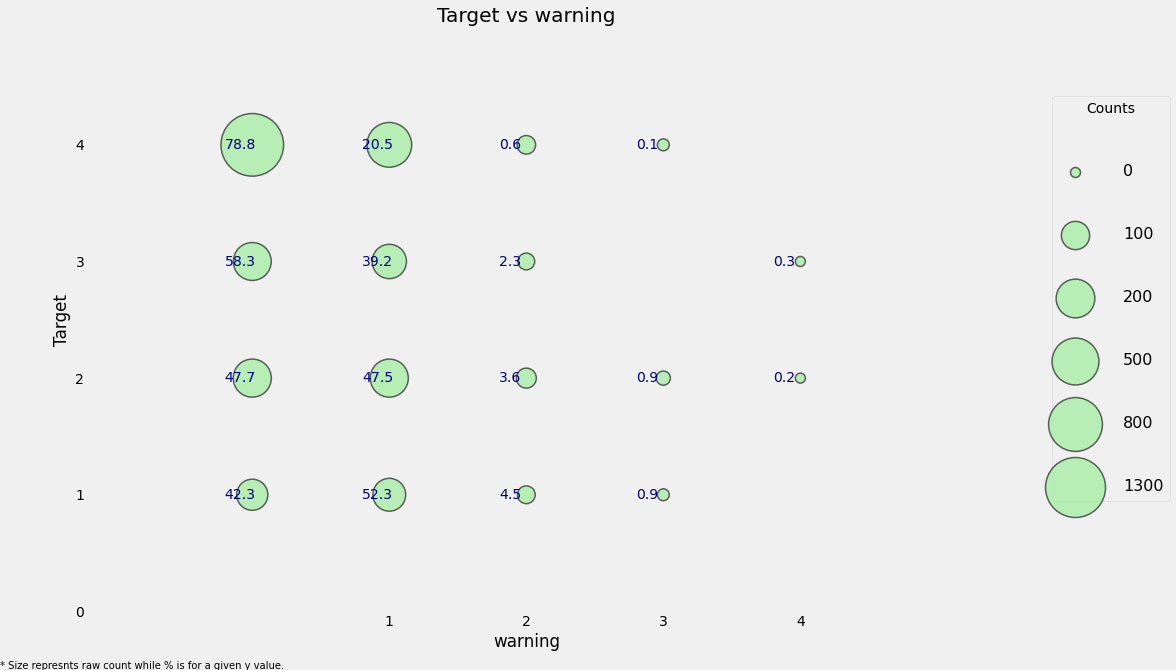

In [ ]:
plot_categoricals('warning', 'Target', data = heads)

The violinplot is not great here because it smooths out the categorical variable with the effect that it looks as if the Target can take on lesser and greater values than in reality. Nonetheless, we can see a high concentration of households that have no warning signs and have the lowest level of poverty. It looks as if this may be a useful feature, but we can't know for sure until we get to modeling!

The final household feature we can make for now is a bonus where a family gets a point for having a refrigerator, computer, tablet, or television.

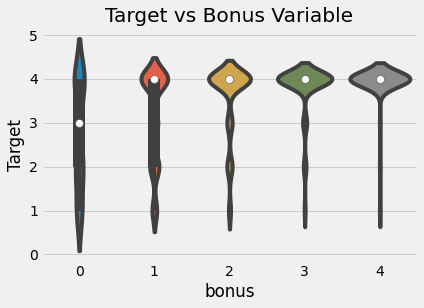

In [ ]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

sns.violinplot('bonus', 'Target', data = heads,
                figsize = (10, 6));
plt.title('Target vs Bonus Variable');

### Per Capita Features
Additional features we can make calculate the number of certain measurements for each person in the household

In [ ]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

### Exploring Household Variables
After going to all the trouble of getting our features in order, now we can take a look at them in relation to the Target. We've already done a little of this, but now we can try to quantify relationships.

In [ ]:
# use only training data
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns = {'Target':'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index':'feature'})

print('most negatively correlated variables: ')
print(pcorrs.head(5))

print('\n')

print('most positively correlated variables: ')
print(pcorrs.dropna().tail())

most negatively correlated variables: 
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4         eviv1 -0.217908


most positively correlated variables: 
               feature     pcorr
97   phones-per-capita  0.299026
98               floor  0.307605
99    walls+roof+floor  0.332446
100           meaneduc  0.333652
101             Target  1.000000


In [ ]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# iterate through each column
for c in heads:
    # only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # calculate spearman correlation
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)
        
scorrs = pd.DataFrame({'feature' : feats, 
                       'scorr' : scorr,
                       'pvalue' : pvalues}).sort_values('scorr')

The Spearman correlation coefficient calculation also comes with a pvalue indicating the significance level of the relationship. Any pvalue less than 0.05 is genearally regarded as significant, although since we are doing multiple comparisons, we want to divide the p-value by the number of comparisons, a process known as the Bonferroni correction.

In [ ]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations:')
print(scorrs.dropna().tail())

Most negative Spearman correlations:
       feature     scorr        pvalue
97     warning -0.307326  4.682829e-66
68  dependency -0.281516  2.792620e-55
85   hogar_nin -0.236225  5.567218e-39
80        r4t1 -0.219226  1.112230e-33
49       eviv1 -0.217803  2.952571e-33

Most positive Spearman correlations:
              feature     scorr        pvalue
23          cielorazo  0.300996  2.611808e-63
95              floor  0.309638  4.466091e-67
99  phones-per-capita  0.337377  4.760104e-80
96   walls+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


In [ ]:
corrs = pcorrs.merge(scorrs, on = 'feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,scorr,pvalue,diff
77,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119
85,v18q1,0.197493,0.244200,1.282664e-41,-0.046708
87,tablets-per-capita,0.204638,0.248642,3.951568e-43,-0.044004
2,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691
97,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351


In [ ]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,scorr,pvalue,diff
57,techozinc,0.014357,0.003404,8.528369e-01,0.010954
49,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549
88,edjefe,0.235687,0.214736,2.367521e-32,0.020951
66,edjefa,0.052310,0.005114,7.804715e-01,0.047197
17,dependency,-0.126465,-0.281516,2.792620e-55,0.155051


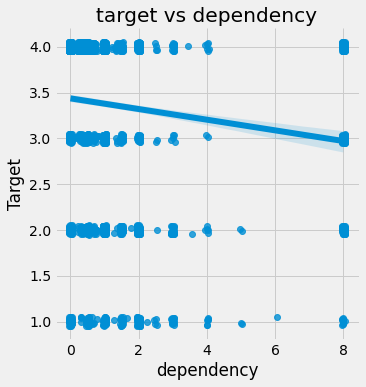

In [ ]:
sns.lmplot('dependency', 'Target', fit_reg = True, data = train_heads, x_jitter = 0.05, y_jitter = 0.05);
plt.title('target vs dependency');

It's hard to see the relationship, but it's slightly negative: as the dependency increases, the value of the Target decreases. This makes sense: the dependency is the number of dependent individuals divided by the number of non-dependents. As we increase this value, the poverty severty tends to increase: having more dependent family members (who usually are non-working) leads to higher levels of poverty because they must be supported by the non-dependent family members.

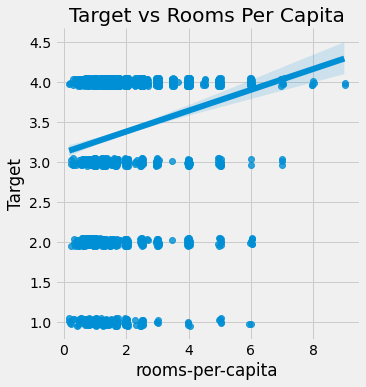

In [ ]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Rooms Per Capita');

#### Correlation Heatmap

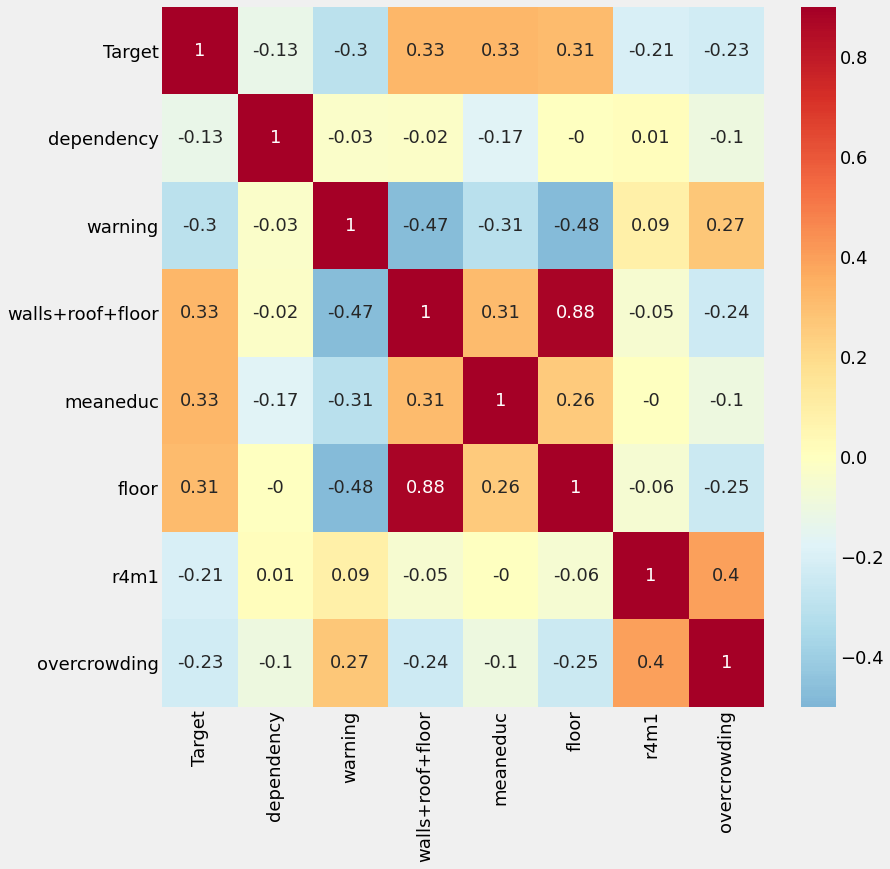

In [ ]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

# calculate the correlations
corr_mat = train_heads[variables].corr().round(2)

# draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.9, center = 0,
            cmap = plt.cm.RdYlBu_r, annot = True);

This plot shows us that there are a number of variables that have a weak correlation with the Target. There are also high correlations between some variables (such as floor and walls+roof+floor) which could pose an issue because of collinearity.

#### Features Plot

For the final exploration of the household level data, we can make a plot of some of the most correlated variables with the Target. This shows scatterplots on the upper triangle, kernel density estimate (kde) plots on the diagonal, and 2D KDE plots on the lower triangle.

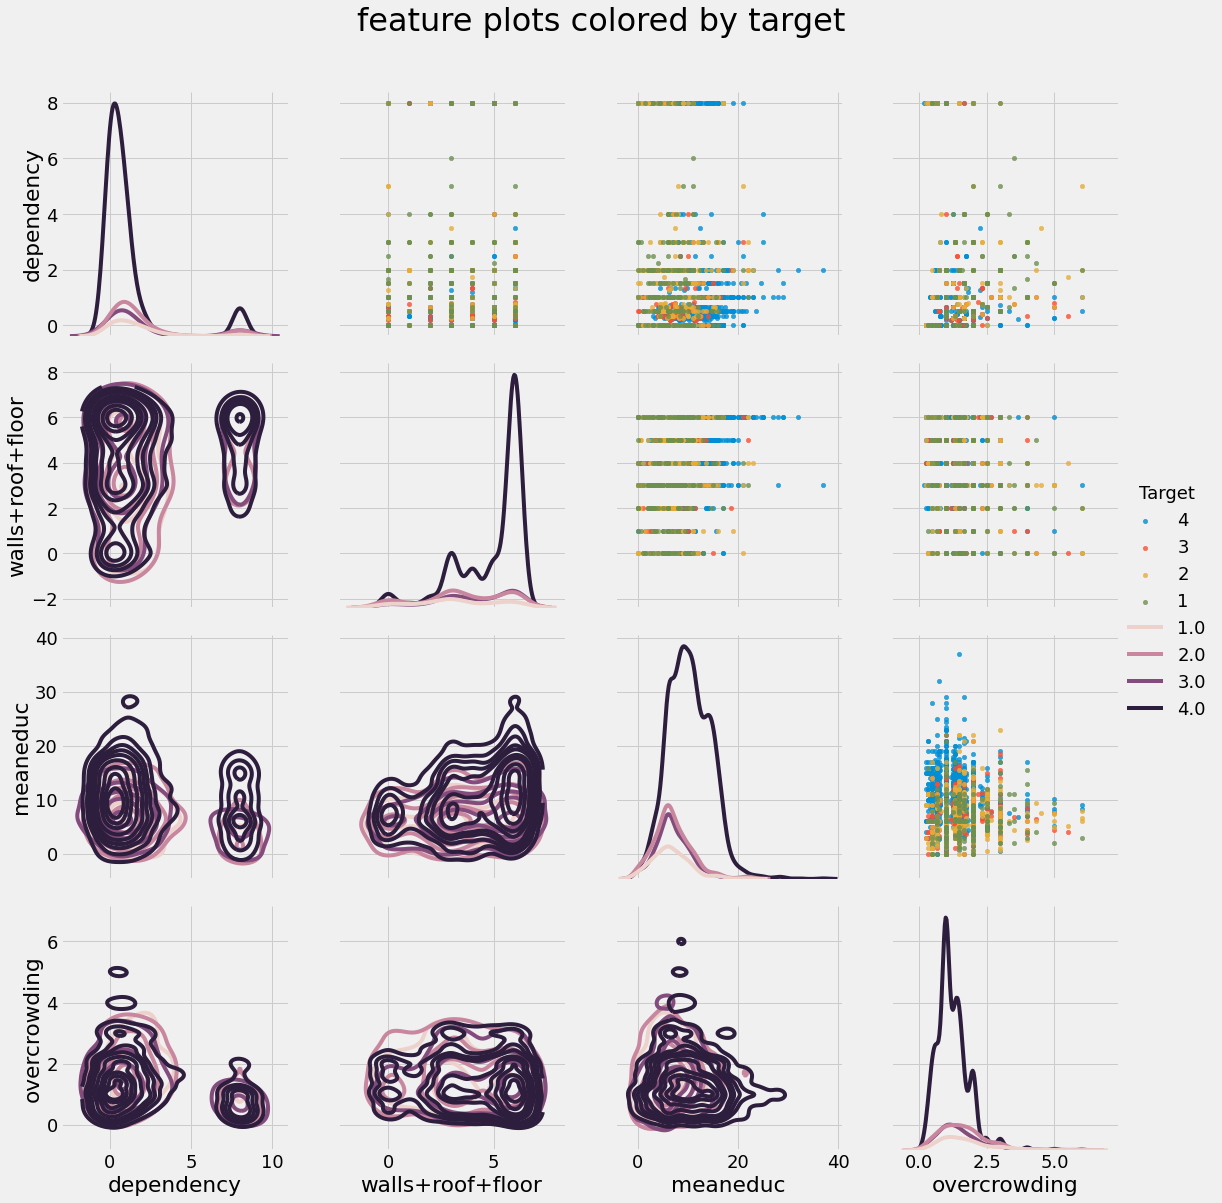

In [ ]:
# copy the data for plotting
plot_data = train_heads[['Target', 'dependency', 'walls+roof+floor',
                         'meaneduc', 'overcrowding']]

# create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 4, diag_sharey = False,
                    hue = 'Target', hue_order = [4, 3, 2, 1],
                    vars = [x for x in list(plot_data.columns) if x != 'Target'])

# upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.8, s = 20)

# diagonal is a histogram
grid.map_diag(sns.kdeplot)

# bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.Oranges_r);
grid = grid.add_legend()
plt.suptitle('feature plots colored by target', size = 32, y = 1.05);

In [ ]:
household_feats = list(heads.columns)

### Individual Level Variables
There are two types of individual level variables: Boolean (1 or 0 for True or False) and ordinal (discrete values with a meaningful ordering).

In [ ]:
ind = data[id_ + ind_bool + ind_ordered]

### Redundant Individual Variables
We can do the same process we did with the household level variables to identify any redundant individual variables. We'll focus on any variables that have an absolute magnitude of the correlation coefficient greater than 0.95.

In [ ]:
# create coreelation matrix
corr_matrix = ind.corr()

# select upper triagnle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

In [ ]:
ind = ind.drop(columns = 'male')

### Creating Ordinal Variables
Much as we did with the household level data, we can map existing columns to an ordinal variable. Here we will focus on the instlevel_ variables which indicate the amount of education an individual has from instlevel1: no level of education to instlevel9: postgraduate education.

To create the ordinal variable, for each individual, we will simply find which column is non-zero. The education has an inherent ordering (higher is better) so this conversion to an ordinal variable makes sense in the problem context.

In [ ]:
ind[[ c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


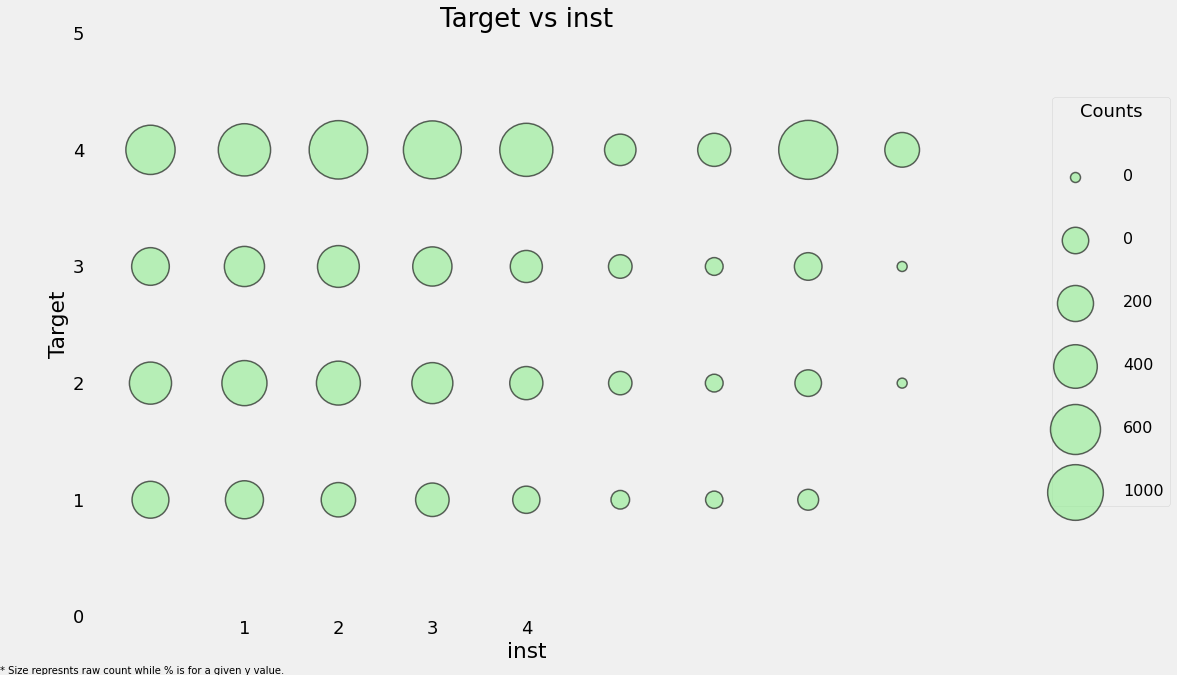

In [ ]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

plot_categoricals('inst', 'Target', ind, annotate = False);

Higher levels of education seem to correspond to less extreme levels of poverty. We do need to keep in mind this is on an individual level though and we eventually will have to aggregate this data at the household level.

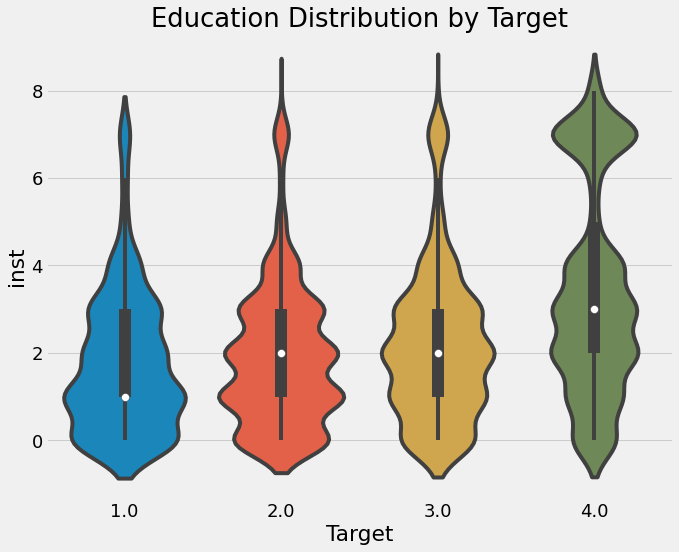

In [ ]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'Target', y = 'inst', data = ind);
plt.title('Education Distribution by Target');

### Feature Construction
We can make a few features using the existing data. For example, we can divide the years of schooling by the age.

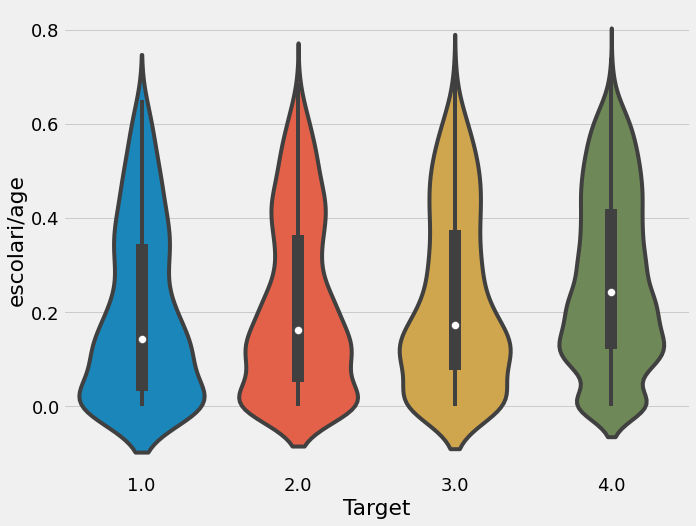

In [ ]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize = (10, 8))
sns.violinplot('Target', 'escolari/age', data = ind);

In [ ]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

### Feature Engineering through Aggregations
In order to incorporate the individual data into the household data, we need to aggregate it for each household. The simplest way to do this is to groupby the family id idhogar and then agg the data. For the aggregations for ordered or continuous variables, we can use six, five of which are built in to pandas, and one of which we define ourselves range_. The boolean aggregations can be the same, but this will create many redundant columns which we will then need to drop. For this case, we'll use the same aggregations and then go back and drop the redundant columns.

In [ ]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                                 \
           min max sum count  std range_ min max sum count       std range_   
idhogar                                                                       
000a08204    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   

          female                                estadocivil1                \
             min max sum count       std range_          min max sum count   
idhogar                                                                      
000a08204      0   1   1     3  0.577350      1            0   1   1     3   
000bce7c4      0   1   1     2  0.707107      1            0   0   0     2   
001845fb0      0   1   2     4  0.577350      1            0   0   0     4   
001ff74ca      1   1   2     2  0.000000      0            0   1   1     2   
003123ec2      0   1   1     4  0.500000      1            0   1   2     4   

                           estadocivil2                                \
                std range_          min max sum count      std range_   
idhogar                                                                 
000a08204  0.577350      1            0   1   2     3  0.57735      1   
000bce7c4  0.000000      0            0   0   0     2  0.00000      0   
001845fb0  0.000000      0            0   1   2     4  0.57735      1   
001ff74ca  0.707107      1            0   0   0     2  0.00000      0   
003123ec2  0.577350      1            0   1   2     4  0.57735      1   

          estadocivil3                           estadocivil4                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            1   1   2     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   0   0     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                      estadocivil5                                 \
           std range_          min max sum count       std range_   
idhogar                                                             
000a08204  0.0      0            0   0   0     3  0.000000      0   
000bce7c4  0.0      0            0   0   0     2  0.000000      0   
001845fb0  0.0      0            0   0   0     4  0.000000      0   
001ff74ca  0.0      0            0   1   1     2  0.707107      1   
003123ec2  0.0      0            0   0   0     4  0.000000      0   

          estadocivil6                           estadocivil7                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            0   0   0     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   1   2     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                          parentesco1                                 \
               std range_         min max sum count       std range_   
idhogar                                                                
000a08204  0.00000      0           0   1   1     3  0.577350      1   
000bce7c4  0.00000      0           0   1   1     2  0.70710

In [ ]:
# rename
new_col = []

# make levels by arregation
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-std,dis-range_,female-min,female-max,female-sum,female-count,female-std,female-range_,estadocivil1-min,estadocivil1-max,estadocivil1-sum,estadocivil1-count,estadocivil1-std,estadocivil1-range_,estadocivil2-min,estadocivil2-max,estadocivil2-sum,estadocivil2-count,estadocivil2-std,estadocivil2-range_,estadocivil3-min,estadocivil3-max,estadocivil3-sum,estadocivil3-count,estadocivil3-std,estadocivil3-range_,estadocivil4-min,estadocivil4-max,estadocivil4-sum,estadocivil4-count,estadocivil4-std,estadocivil4-range_,estadocivil5-min,estadocivil5-max,estadocivil5-sum,estadocivil5-count,estadocivil5-std,estadocivil5-range_,estadocivil6-min,estadocivil6-max,estadocivil6-sum,estadocivil6-count,estadocivil6-std,estadocivil6-range_,estadocivil7-min,estadocivil7-max,estadocivil7-sum,estadocivil7-count,estadocivil7-std,estadocivil7-range_,parentesco1-min,parentesco1-max,parentesco1-sum,parentesco1-count,parentesco1-std,parentesco1-range_,parentesco2-min,parentesco2-max,parentesco2-sum,parentesco2-count,parentesco2-std,parentesco2-range_,parentesco3-min,parentesco3-max,parentesco3-sum,...,instlevel5-count,instlevel5-std,instlevel5-range_,instlevel6-min,instlevel6-max,instlevel6-sum,instlevel6-count,instlevel6-std,instlevel6-range_,instlevel7-min,instlevel7-max,instlevel7-sum,instlevel7-count,instlevel7-std,instlevel7-range_,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-count,instlevel8-std,instlevel8-range_,instlevel9-min,instlevel9-max,instlevel9-sum,instlevel9-count,instlevel9-std,instlevel9-range_,mobilephone-min,mobilephone-max,mobilephone-sum,mobilephone-count,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,rez_esc-sum,rez_esc-count,rez_esc-std,rez_esc-range_,escolari-min,escolari-max,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_,inst-min,inst-max,inst-sum,inst-count,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-count,escolari/age-std,escolari/age-range_,inst/age-min,inst/age-max,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.000000,0,0,0,0,3,0.0,0,0,0,0,3,0.00000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,1,...,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,1,2,3,0.577350,1,0,0,0,3,0.0,0,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0,7,14,3,4.041452,7,0.000000,0.500000,0.900000,3,0.264575,0.500000,0.000000,0.250000,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,2,0.000000,0,0,0,0,2,0.00000,0,1,1,2,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,0,0,0,2,0.00000,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,...,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,0,5,5,2,3.535534,5,60,63,123,2,2.121320,3,0,1,1,2,0.707107,1,0.000000,0.083333,0.083333,2,0.058926,0.083333,0.000000,0.016667,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,2,4,0.577350,1,0,0,0,4,0.000000,0,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,0,0,4,0.0,0,0,1,2,4,0.57735,1,0,1,1,4,0.500000,1,0,1,1,4,0.500000,1,0,1,2,...,4,0.5,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,1,1,4,0.500000,1,0,0,0,4,0.0,0,1,1,4,4,0.0,0,0.0,0.0,0.0,3,0.0,0.0,6,14,41,4,3.304038,8,19,52,142,4,16.421531,33,2,7,16,4,2.160247,5,0.115385,0.526316,1.397906,4,0.183106,0.410931,0.038462,0.166667,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,0.000000,0,1,1,2,2,0.000000,0,0,1,1,2,0.707107,1,0,0,0,2,0.00

In [ ]:
# create correlation matrix
corr_matrix = ind_agg.corr()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'there are {len(to_drop)} correlated columns to remove.')

there are 111 correlated columns to remove.


In [ ]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print(f'final feature shape: ', final.shape)

final feature shape:  (10307, 228)


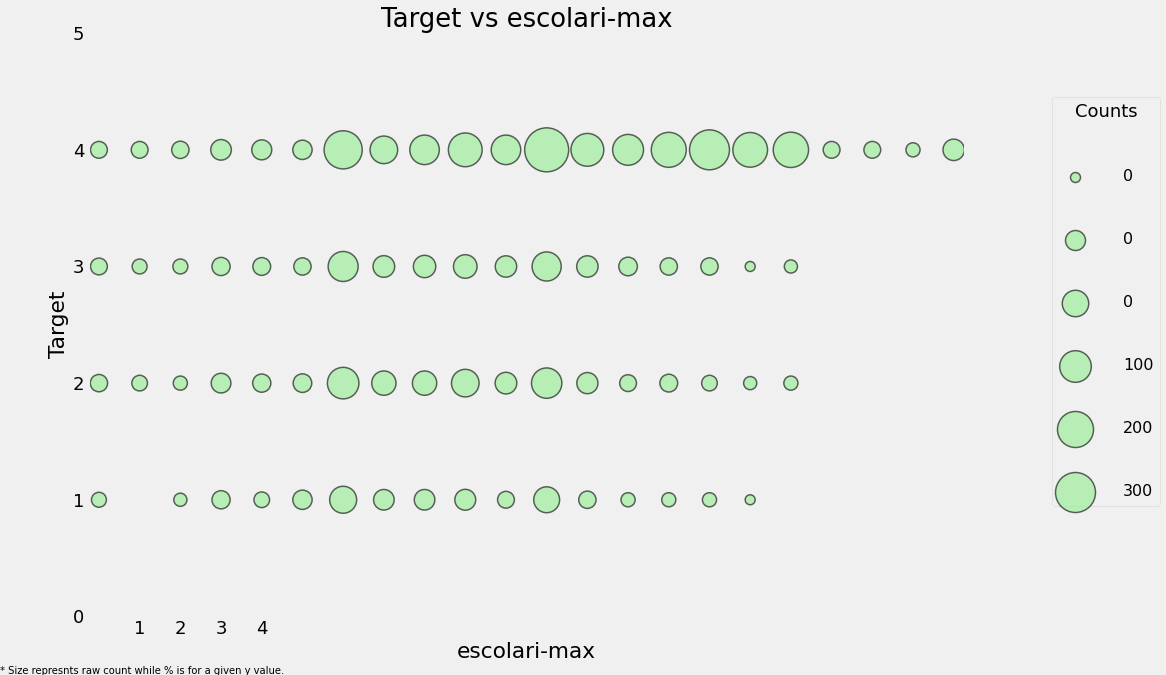

In [ ]:
corrs = final.corr()['Target']
plot_categoricals('escolari-max', 'Target', final, annotate=False);

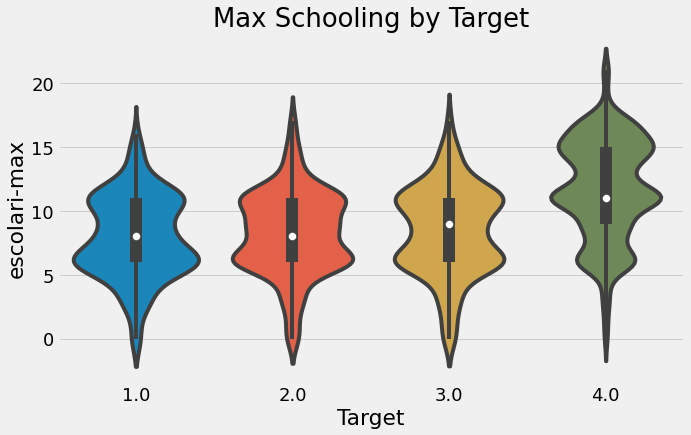

In [ ]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

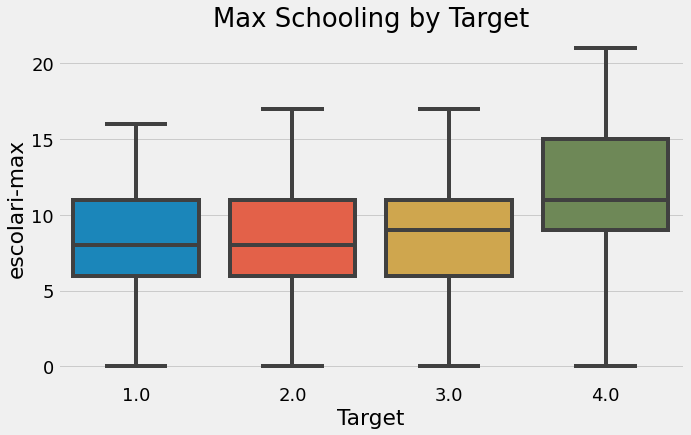

In [ ]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

## Machine Learning Modeling
Once feature engineering/construction is done, we can get started with the machine learning! All of our data (both training and testing) is aggregated for each household and so can be directly used in a model. To first show the process of modeling, we'll use the capable Random Forest Classifier in Scikit-Learn. This probably won't get us to the top of the leaderboard, but it will allow us to establish a baseline. Later we'll try several other models including the powerful Gradient Boosting Machine.

To assess our model, we'll use 10-fold cross validation on the training data. This will essentially train and test the model 10 times using different splits of the training data. 10-fold cross validation is an effective method for estimating the performance of a model on the test set. We want to look at the average performance in cross validation as well as the standard deviation to see how much scores change between the folds. We use the F1 Macro measure to evaluate performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better = True, average = 'macro' )

In [ ]:
# labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# extract the training data
# isnull() 메소드는 관측치가 결측이면 True, 결측이 아니면 False의 boollean 값을 반환합니다.
# notnull() 메소드는 관측치가 결측이면 False, 결측이 아니면 True를 반환합니다.(isnull() 과 정반대)
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

# submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()

Because we are going to be comparing different models, we want to scale the features (limit the range of each column to between 0 and 1). For many ensemble models this is not necessary, but when we use models that depend on a distance metric, such as KNearest Neighbors or the Support Vector Machine, feature scaling is an absolute necessity. When comparing different models, it's always safest to scale the features. We also impute the missing values with the median of the feature.

For imputing missing values and scaling the features in one step, we can make a pipeline. This will be fit on the training data and used to transform the training and testing data.

In [ ]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.355 with std = 0.0393


The data has no missing values and is scaled between zero and one. This means it can be directly used in any Scikit-Learn model.

## Feature Importances
With a tree-based model, we can look at the feature importances which show a relative ranking of the usefulness of features in the model. These represent the sum of the reduction in impurity at nodes that used the variable for splitting, but we don't have to pay much attention to the absolute value. Instead we'll focus on relative scores.

If we want to view the feature importances, we'll have to train a model on the whole training set. Cross validation does not return the feature importances.

In [ ]:
model.fit(train_set, train_labels)

# feature importances into a dataframe
feature_importances = pd.DataFrame({'feature':features, 'importance':model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000555
1,hacapo,0.000486
2,v14a,0.000462
3,refrig,0.001603
4,paredblolad,0.007236


In [ ]:
# short function useful and can apply lots of position

def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    #bar plot of n most importance features
    df.loc[:n, :].plot.barh(y = 'importance_normalized',
                            x = 'feature', color = 'darkgreen', edgecolor = 'k',
                            figsize = (12, 8), legend = False, linewidth = 2)
    
    plt.xlabel('normalized importance', size = 18);
    plt.ylabel('');
    plt.title(f'{n} Most importance features', size = 18);
    plt.gca().invert_yaxis()
    
    if threshold:
        # cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df        

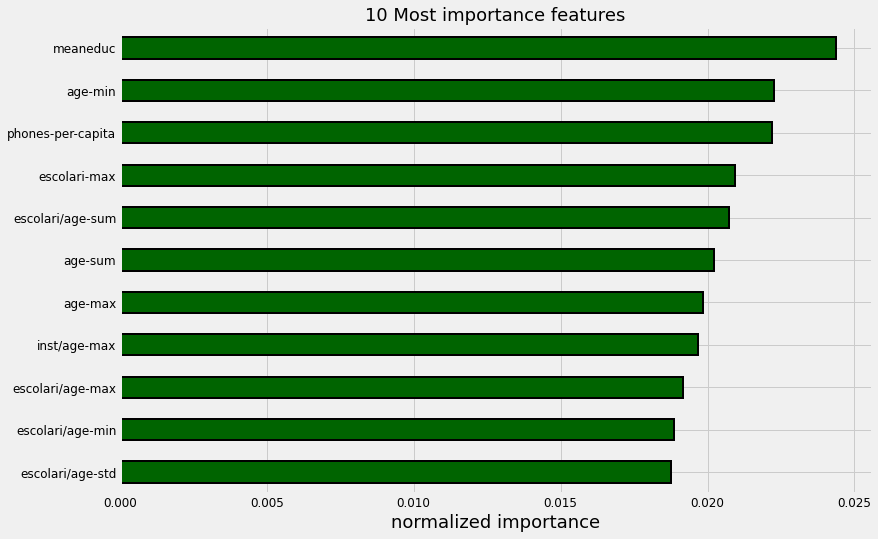

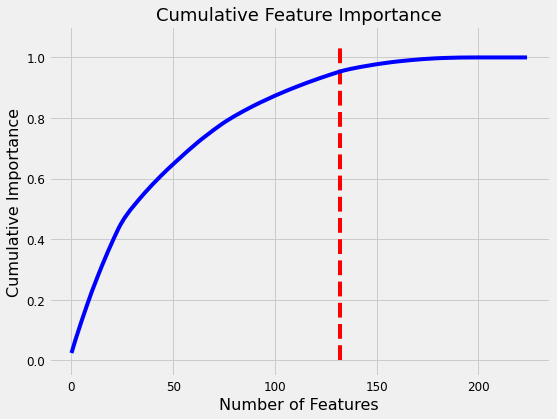

132 features required for 95% of cumulative importance.


In [ ]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

Education reigns supreme! The most important variable is the average amount of education in the household, followed by the maximum education of anyone in the household. I have a suspicion these variables are highly correlated (collinear) which means we may want to remove one of them from the data. The other most important features are a combination of variables we created and variables that were already present in the data.

It's interesting that we only need 106 of the ~180 features to account for 90% of the importance. This tells us that we may be able to remove some of the features. However, feature importances don't tell us which direction of the feature is important (for example, we can't use these to tell whether more or less education leads to more severe poverty) they only tell us which features the model considered relevant.

In [ ]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

    plt.figure(figsize = (12, 8))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['Target'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

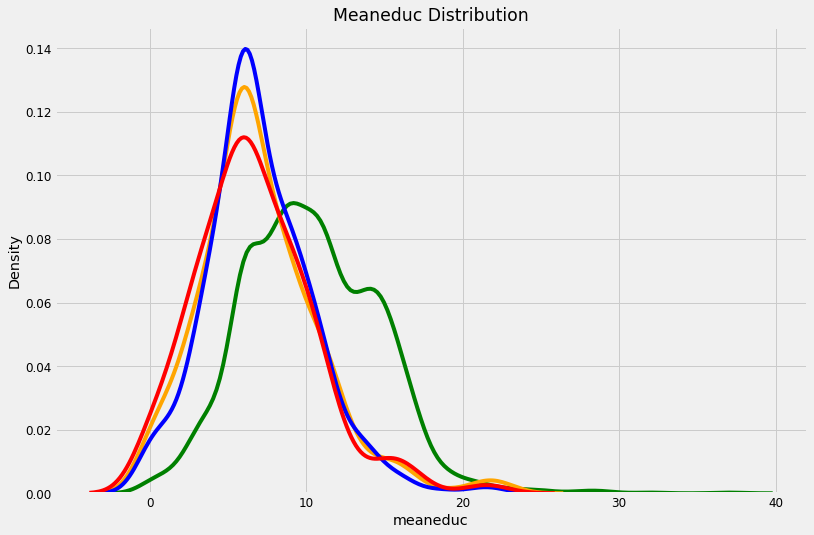

In [ ]:
kde_target(final, 'meaneduc')

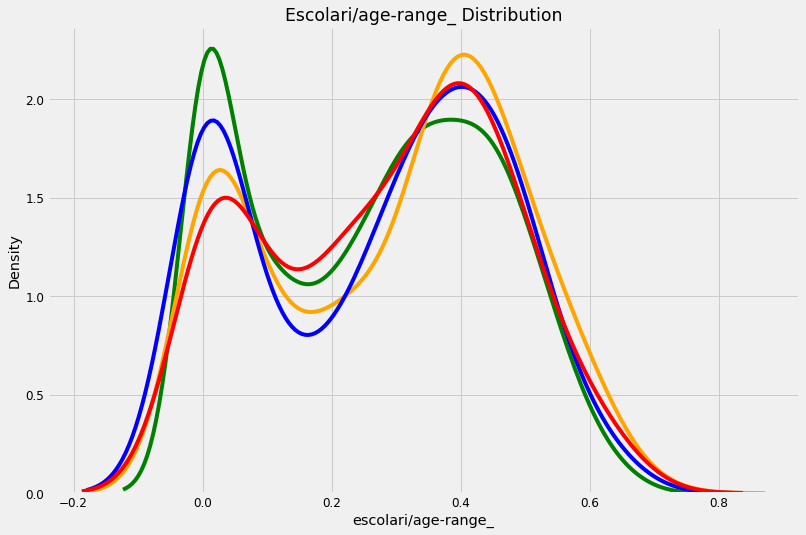

In [ ]:
kde_target(final, 'escolari/age-range_')

## Making a Submission
In order to make a submission, we need the test data. Fortunately, we have the test data formatted in exactly the same manner as the train data.

The format of a testing submission is shown below. Although we are making predictions for each household, we actually need one row per individual (identified by the Id) but only the prediction for the head of household is scored.

In [ ]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

In [ ]:
def submit(model, train, train_labels, test, test_ids):
    # train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar':test_ids,
                                'Target':predictions})
    
    # make a submission dataframe
    submission = submission_base.merge(predictions, on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
    
    # fill in households missing a head
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    return submission

In [ ]:
rf_submission = submit(RandomForestClassifier(n_estimators = 100, 
                                              random_state=10, n_jobs = -1), 
                         train_set, train_labels, test_set, test_ids)

rf_submission.to_csv('rf_submission.csv', index = False)